# Pole Position: Predicting Final Position using Grid Position in Formula 1: An Introduction to Bayesian Inference using PyMC library

## Import Libraries and Load Data

This section imports necessary libraries for data handling and visualization (`pandas`, `numpy`, `matplotlib.pyplot`), loads the racing results data, and displays the initial few rows for a quick overview.

In [1]:
# import libraries and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading the dataset
results = pd.read_csv('../data/results.csv',encoding = "utf-8")
results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


## Data Preparation and Analysis

Here, we select the columns relevant to understanding the influence of grid positions on final positions. The data is cleaned by removing null values and filtering out rows where grid or final positions are zero.

In [2]:
# this is to analyze how grid position influences final position
grid_cols = ['raceId', 'driverId', 'constructorId', 'grid', 'position']

grid_final = results[grid_cols]
grid_final.head()


,raceId,driverId,constructorId,grid,position
0,18,1,1,1,1
1,18,2,2,5,2
2,18,3,3,7,3
3,18,4,4,11,4
4,18,5,1,3,5


In [3]:
grid_final = grid_final.copy() # create a copy to avoid changing the original

In [4]:
# remove null values
grid_final.replace('\\N', np.nan, inplace=True)
grid_final.dropna(inplace=True)

# Filter out rows where 'grid' or 'position' is zero
# Either cause driver didn't participate or finish the race
grid = grid_final[(grid_final['grid'] != 0) & (grid_final['position'] != 0)]

grid = grid.copy()
# change any float objects to integer
grid['grid'] = grid['grid'].astype(int)
grid['position'] = grid['position'].astype(int)

In [5]:
grid.head()

,raceId,driverId,constructorId,grid,position
0,18,1,1,1,1
1,18,2,2,5,2
2,18,3,3,7,3
3,18,4,4,11,4
4,18,5,1,3,5


## Statistical Analysis of Pole Positions

This analysis calculates how often starting in pole position (grid position 1) results in a win (final position 1), both in count and percentage form.

In [6]:
# Filter the dataset for pole positions (grid position 1)
pole_positions = grid[grid['grid'] == 1]

# Count the number of times the pole position resulted in a win (positionOrder 1)
pole_wins = pole_positions[pole_positions['position'] == 1].shape[0]

# Print out the number of pole position wins
print(f"Number of wins from pole position: {pole_wins}")


Number of wins from pole position: 468


In [7]:
# Calculate the total number of races that had a pole position (for normalization)
total_pole_positions = pole_positions.shape[0]

# Calculate the percentage of races won from pole position
percentage_pole_wins = (pole_wins / total_pole_positions) * 100

# Print out the percentage of races won from pole position
print(f"Percentage of races won from pole position: {percentage_pole_wins:.2f}%")

Percentage of races won from pole position: 55.32%


## Visualization of Grid vs. Final Position

A scatter plot visualizes the distribution of final positions for each grid position, with point size indicating the count of occurrences for each grid-final position pair.

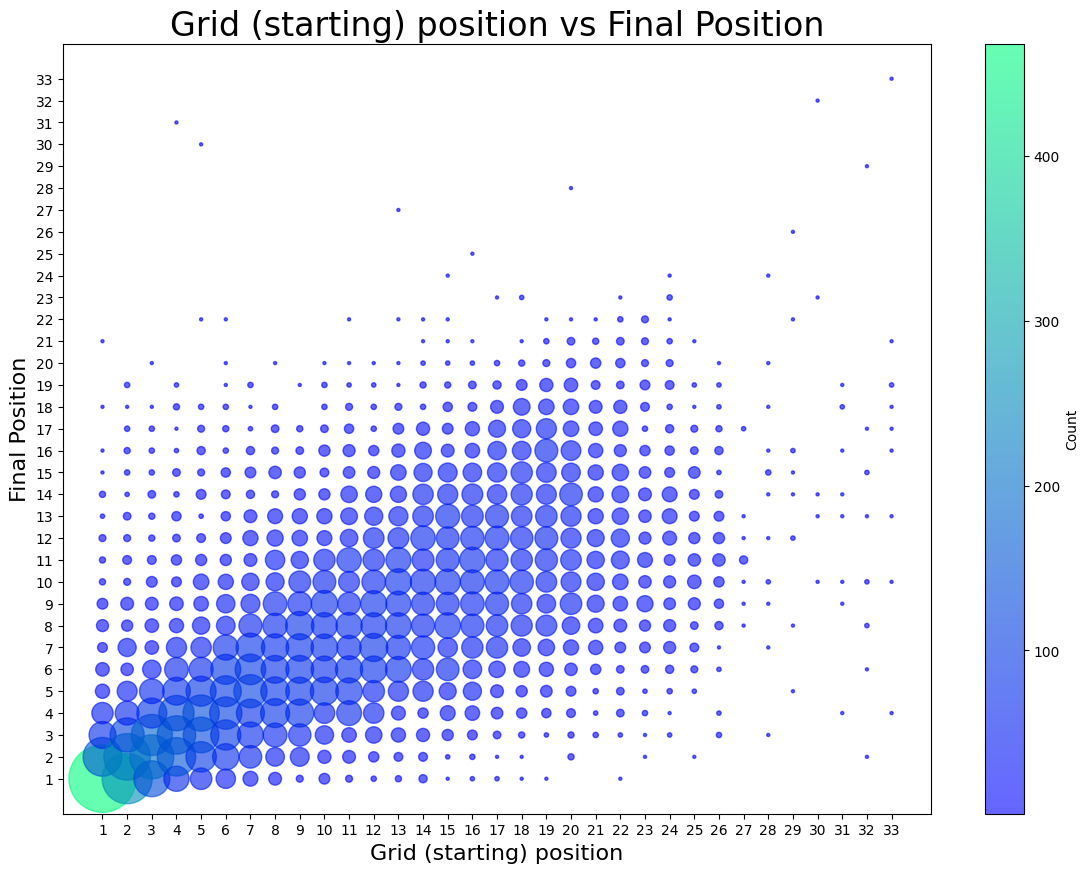

In [8]:
# Visualize
from matplotlib.colors import Normalize

# Counting occurrences of each pair
df = pd.DataFrame({'X': grid['grid'], 'y': grid['position']})
counts = df.groupby(['X', 'y']).size().reset_index(name = 'counts')

# Plotting
size_scale = 5  # Adjust the size scale for visibility
norm = Normalize(vmin = counts['counts'].min(), vmax = counts['counts'].max())

plt.figure(figsize=(14, 10))
scatter = plt.scatter(counts['X'], counts['y'], s = counts['counts'] * size_scale, 
                    c = counts['counts'], cmap = 'winter', norm = norm, alpha = 0.6)

# Create colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Count')

# Discrete axis with integers
plt.xticks(np.arange(min(counts['X']), max(counts['X'])+1, 1))
plt.yticks(np.arange(min(counts['y']), max(counts['y'])+1, 1))
plt.xlabel('Grid (starting) position', fontsize = 16)
plt.ylabel('Final Position', fontsize = 16)
plt.title('Grid (starting) position vs Final Position', fontsize = 24)
plt.show()

## Bayesian Linear Regression Model

We build a Bayesian linear regression model to understand the relationship between starting grid position and final race position. This involves setting up priors, defining the model, and sampling from the posterior.

In [9]:
# Import necessary libraries
import pymc as pm
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [10]:
# Linear Model with Normal likelihood
with pm.Model() as linear_model:
    # Priors 
    intercept = pm.Uniform('intercept', lower = 0, upper = 0.1)
    slope = pm.Normal('slope', mu = 0, sigma = 10)
    sigma = pm.Uniform('sigma', 0, 30)
    
    # Data 
    x = pm.MutableData('x', grid['grid'])
    y = pm.MutableData('y', grid['position'])

    # Regression Mean (Linear Function)
    mu = pm.Deterministic('mu', intercept + slope * x)
    
    # Likelihood using Normal distribution
    pm.Normal('likelihood', mu = mu, sigma = sigma, observed = y)
    
    # Sampling 
    linear_trace = pm.sample(tune = 1000, draws = 1000, chains = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.
/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


## Model Diagnostics and Prediction

The trace and rank plots help diagnose the sampling process and assess convergence. Summary statistics for the intercept, slope, and sigma offer insights into the parameter estimates. 

/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


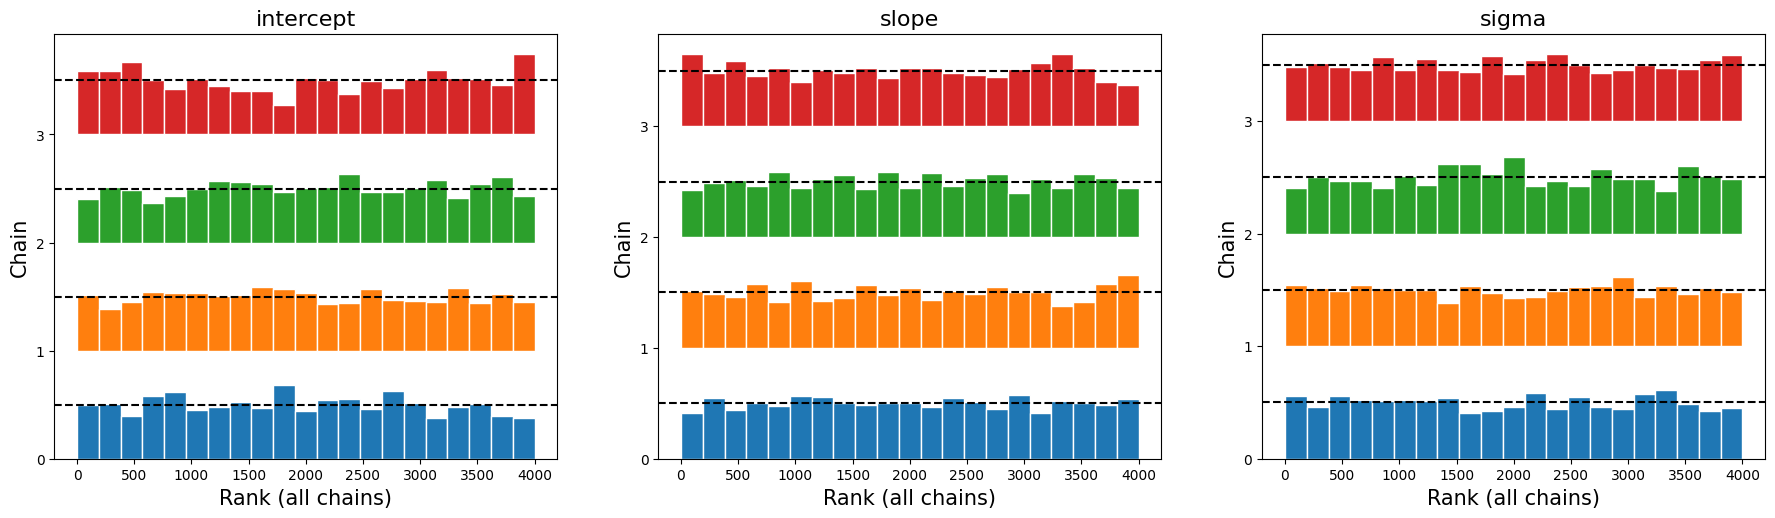

In [11]:
az.plot_rank(linear_trace, var_names=['intercept', 'slope', 'sigma'])
plt.show()

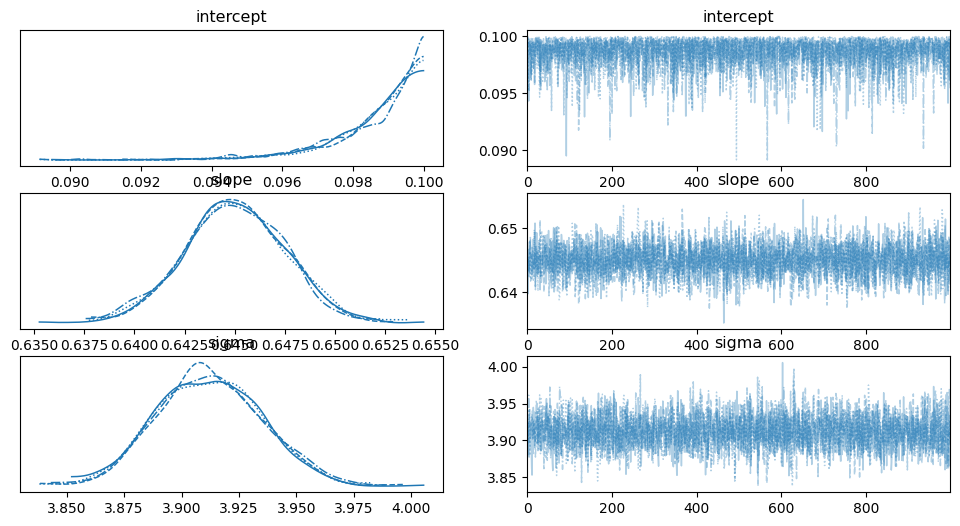

In [12]:
az.plot_trace(linear_trace, var_names=['intercept', 'slope', 'sigma'])
plt.show()

In [13]:
az.summary(linear_trace, var_names=['intercept', 'slope', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.099,0.001,0.096,0.100,0.0,0.0,2765.0,1839.0,1.0
slope,0.645,0.002,0.640,0.650,0.0,0.0,3699.0,3023.0,1.0
sigma,3.912,0.023,3.873,3.956,0.0,0.0,3477.0,2667.0,1.0


## Visualization

Using the estimates, we predict final positions for a range of grid positions and visualize these predictions with the observed data and the 94% High-Density Interval (HDI) for the regression line.

In [14]:
# Compute mean values for intercept and slope
intercept_samples = linear_trace.posterior['intercept'].values.flatten()
slope_samples = linear_trace.posterior['slope'].values.flatten()

intercept_mean = intercept_samples.mean()
slope_mean = slope_samples.mean()

# Predicted values using the mean parameter estimates
grid_vals = np.linspace(min(grid['grid']), 
                     max(grid['grid']), 1000)
final_vals = intercept_mean + slope_mean * grid_vals

# Compute posterior distributions of the predictions
posterior_mu = (intercept_samples[:, None] + slope_samples[:, None] * grid_vals)

/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


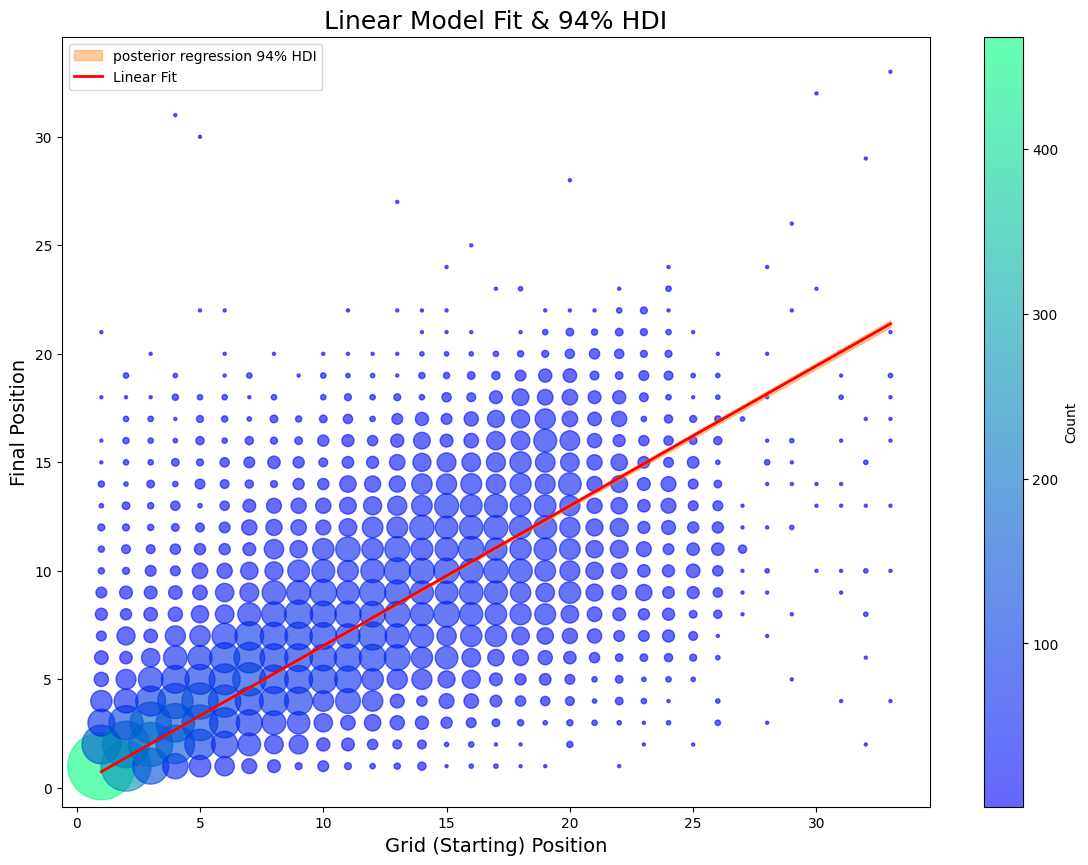

In [15]:
# Plot the data with the line of best fit & HDI
plt.figure(figsize = (14, 10))
size_scale = 5  # Adjust the size scale for visibility
norm = Normalize(vmin = counts['counts'].min(), vmax = counts['counts'].max())


scatter = plt.scatter(counts['X'], counts['y'], s = counts['counts'] * size_scale, 
                    c = counts['counts'], cmap = 'winter', norm = norm, alpha = 0.6)
# Create colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Count')

az.plot_hdi(grid_vals, posterior_mu, hdi_prob = 0.94, color = 'C1', 
            fill_kwargs = {'alpha': 0.4, 'label': 'posterior regression 94% HDI'})
plt.plot(grid_vals, final_vals, c = 'red', label = 'Linear Fit', linewidth = 2) # the line
plt.title('Linear Model Fit & 94% HDI', fontsize=18)
plt.xlabel('Grid (Starting) Position', fontsize=14)
plt.ylabel('Final Position', fontsize=14)
plt.legend()
plt.show()